In [167]:
import sys
import os

sys.path.append(os.path.abspath(".."))

print(sys.path[-1])


d:\project


In [168]:
import pandas as pd
import numpy as np

# Display settings (optional but helpful)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

DATA_PATH = "D:\\project\\data\\FMCG_2022_2024.csv"

In [169]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Display settings (optional but helpful)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)

DATA_PATH = "D:\\project\\data\\FMCG_2022_2024.csv"


In [170]:
df = pd.read_csv(DATA_PATH)
df.head()


,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,21-01-2022,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,21-01-2022,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,21-01-2022,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,21-01-2022,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,21-01-2022,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


In [171]:
df.shape


(190757, 14)

In [172]:
df.columns


Index(['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region',
       'pack_type', 'price_unit', 'promotion_flag', 'delivery_days',
       'stock_available', 'delivered_qty', 'units_sold'],
      dtype='object')

In [173]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190757 entries, 0 to 190756
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             190757 non-null  object 
 1   sku              190757 non-null  object 
 2   brand            190757 non-null  object 
 3   segment          190757 non-null  object 
 4   category         190757 non-null  object 
 5   channel          190757 non-null  object 
 6   region           190757 non-null  object 
 7   pack_type        190757 non-null  object 
 8   price_unit       190757 non-null  float64
 9   promotion_flag   190757 non-null  int64  
 10  delivery_days    190757 non-null  int64  
 11  stock_available  190757 non-null  int64  
 12  delivered_qty    190757 non-null  int64  
 13  units_sold       190757 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 20.4+ MB


,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
count,190757.000000,190757.000000,190757.000000,190757.000000,190757.000000,190757.000000
mean,5.251979,0.149200,3.004860,157.697652,179.333655,19.919709
std,2.166705,0.356287,1.414626,52.736104,40.037475,11.770077
min,1.500000,0.000000,1.000000,-12.000000,-11.000000,-25.000000
25%,3.380000,0.000000,2.000000,124.000000,152.000000,12.000000
50%,5.250000,0.000000,3.000000,155.000000,179.000000,18.000000
75%,7.130000,0.000000,4.000000,192.000000,206.000000,25.000000
max,9.000000,1.000000,5.000000,405.000000,366.000000,139.000000


In [174]:
df.isnull().sum()


date               0
sku                0
brand              0
segment            0
category           0
channel            0
region             0
pack_type          0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
delivered_qty      0
units_sold         0
dtype: int64

## Phase 2: SQL Schema Design & Database Setup


In [175]:
import sqlite3
from pathlib import Path

DB_PATH = "D:\\project\\data\\fmcg_data.db"


In [176]:
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

print("Database connected at:", Path(DB_PATH).resolve())


Database connected at: D:\project\data\fmcg_data.db


In [177]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
    product_id INTEGER PRIMARY KEY AUTOINCREMENT,
    sku TEXT UNIQUE,
    brand TEXT,
    segment TEXT,
    category TEXT,
    pack_type TEXT
)
""")


In [178]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS markets (
    market_id INTEGER PRIMARY KEY AUTOINCREMENT,
    region TEXT,
    channel TEXT,
    UNIQUE(region, channel)
)
""")


In [179]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS calendar (
    date TEXT PRIMARY KEY,
    year INTEGER,
    month INTEGER,
    quarter INTEGER,
    day_of_week TEXT
)
""")


In [180]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS sales_fact (
    sale_id INTEGER PRIMARY KEY AUTOINCREMENT,
    date TEXT,
    product_id INTEGER,
    market_id INTEGER,
    price_unit REAL,
    promotion_flag INTEGER,
    delivery_days INTEGER,
    stock_available INTEGER,
    delivered_qty INTEGER,
    units_sold INTEGER,
    FOREIGN KEY(date) REFERENCES calendar(date),
    FOREIGN KEY(product_id) REFERENCES products(product_id),
    FOREIGN KEY(market_id) REFERENCES markets(market_id)
)
""")


In [181]:
conn.commit()
print("All tables created successfully")


All tables created successfully


In [182]:
cursor.execute("""
SELECT name FROM sqlite_master
WHERE type='table'
""")
cursor.fetchall()


[('products',),
 ('sqlite_sequence',),
 ('markets',),
 ('calendar',),
 ('sales_fact',)]

## Phase 3: Populate SQL Tables from FMCG Dataset


In [183]:
# Reload dataset to avoid accidental mutations
df_sql = df.copy()

# Convert date to datetime (only for processing, not SQL yet)
df_sql["date"] = pd.to_datetime(df_sql["date"])


C:\Users\BIT\AppData\Local\Temp\ipykernel_8324\1098018713.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_sql["date"] = pd.to_datetime(df_sql["date"])


In [184]:
cursor.execute("DELETE FROM products")
conn.commit()

print("Products table cleared")


Products table cleared


In [185]:
pd.read_sql("SELECT COUNT(*) FROM products", conn)


,COUNT(*)
0,0


In [186]:
pd.read_sql("SELECT * FROM products LIMIT 5", conn)


,product_id,sku,brand,segment,category,pack_type


In [187]:
products_df = (
    df_sql[["sku", "brand", "segment", "category", "pack_type"]]
    .drop_duplicates(subset=["sku"])
    .reset_index(drop=True)
)


In [188]:
products_df["sku"].duplicated().sum()


np.int64(0)

In [189]:
len(products_df), df_sql["sku"].nunique()


(30, 30)

In [190]:
cursor.execute("DELETE FROM products")
conn.commit()


In [191]:
products_df.to_sql(
    "products",
    conn,
    if_exists="append",
    index=False
)

print("Products table populated:", len(products_df))


Products table populated: 30


In [192]:
pd.read_sql("SELECT COUNT(*) AS cnt FROM products", conn)


,cnt
0,30


In [193]:
pd.read_sql("SELECT * FROM products LIMIT 5", conn)


,product_id,sku,brand,segment,category,pack_type
0,91,MI-006,MiBrand1,Milk-Seg3,Milk,Multipack
1,92,MI-026,MiBrand4,Milk-Seg2,Milk,Carton
2,93,YO-029,YoBrand4,Yogurt-Seg2,Yogurt,Single
3,94,YO-005,YoBrand2,Yogurt-Seg1,Yogurt,Multipack
4,95,YO-012,YoBrand1,Yogurt-Seg2,Yogurt,Single


In [194]:
markets_df = (
    df_sql[["region", "channel"]]
    .drop_duplicates()
    .reset_index(drop=True)
)


In [195]:
markets_df.duplicated().sum()


np.int64(0)

In [196]:
len(markets_df), df_sql[["region", "channel"]].drop_duplicates().shape[0]


(9, 9)

In [197]:
cursor.execute("DELETE FROM markets")
conn.commit()


In [198]:
markets_df.to_sql(
    "markets",
    conn,
    if_exists="append",
    index=False
)

print("Markets table populated:", len(markets_df))


Markets table populated: 9


In [199]:
pd.read_sql("SELECT COUNT(*) AS cnt FROM markets", conn)


,cnt
0,9


In [200]:
pd.read_sql("SELECT * FROM markets LIMIT 5", conn)


,market_id,region,channel
0,28,PL-Central,Retail
1,29,PL-North,Retail
2,30,PL-South,Retail
3,31,PL-Central,Discount
4,32,PL-North,Discount


In [201]:
calendar_df = (
    df_sql[["date"]]
    .drop_duplicates()
    .assign(
        year=lambda x: x["date"].dt.year,
        month=lambda x: x["date"].dt.month,
        quarter=lambda x: x["date"].dt.to_period("Q").astype(str),
        day_of_week=lambda x: x["date"].dt.day_name()
    )
    .reset_index(drop=True)
)


In [202]:
calendar_df["date"].duplicated().sum()


np.int64(0)

In [203]:
len(calendar_df), df_sql["date"].nunique()


(1076, 1076)

In [204]:
calendar_df["date"] = calendar_df["date"].astype(str)


In [205]:
cursor.execute("DELETE FROM calendar")
conn.commit()


In [206]:
calendar_df.to_sql(
    "calendar",
    conn,
    if_exists="append",
    index=False
)

print("Calendar table populated:", len(calendar_df))


Calendar table populated: 1076


In [207]:
pd.read_sql("SELECT COUNT(*) AS cnt FROM calendar", conn)


,cnt
0,1076


In [208]:
pd.read_sql("SELECT * FROM calendar LIMIT 5", conn)


,date,year,month,quarter,day_of_week
0,2022-01-21,2022,1,2022Q1,Friday
1,2022-01-22,2022,1,2022Q1,Saturday
2,2022-01-23,2022,1,2022Q1,Sunday
3,2022-01-24,2022,1,2022Q1,Monday
4,2022-01-25,2022,1,2022Q1,Tuesday


In [209]:
product_map = pd.read_sql(
    "SELECT product_id, sku FROM products",
    conn
)


In [210]:
market_map = pd.read_sql(
    "SELECT market_id, region, channel FROM markets",
    conn
)


In [211]:
sales_df = df_sql.merge(product_map, on="sku", how="left")
sales_df = sales_df.merge(market_map, on=["region", "channel"], how="left")


In [212]:
sales_df["product_id"].isnull().sum()


np.int64(0)

In [213]:
sales_df["market_id"].isnull().sum()


np.int64(0)

In [214]:
sales_df["date"].isnull().sum()


np.int64(0)

In [215]:
sales_fact_df = sales_df[
    [
        "date",
        "product_id",
        "market_id",
        "price_unit",
        "promotion_flag",
        "delivery_days",
        "stock_available",
        "delivered_qty",
        "units_sold"
    ]
].copy()


In [216]:
sales_fact_df["date"] = sales_fact_df["date"].astype(str)


In [217]:
cursor.execute("DELETE FROM sales_fact")
conn.commit()


In [218]:
sales_fact_df.to_sql(
    "sales_fact",
    conn,
    if_exists="append",
    index=False,
    chunksize=5000
)

print("Sales fact table populated:", len(sales_fact_df))


Sales fact table populated: 190757


In [219]:
pd.read_sql("SELECT COUNT(*) AS cnt FROM sales_fact", conn)


,cnt
0,190757


In [220]:
pd.read_sql("SELECT * FROM sales_fact LIMIT 5", conn)


,sale_id,date,product_id,market_id,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,572272,2022-01-21,91,28,2.38,0,1,141,128,9
1,572273,2022-01-21,91,29,1.55,1,3,0,129,0
2,572274,2022-01-21,91,30,4.00,0,5,118,161,8
3,572275,2022-01-21,91,31,5.16,0,2,81,114,7
4,572276,2022-01-21,91,32,7.66,0,4,148,204,12


## Phase 4: BUSINESS SQL ANALYTICS

In [221]:
#total unit sold
pd.read_sql("""
SELECT 
    SUM(units_sold) AS total_units_sold
FROM sales_fact
""", conn)


,total_units_sold
0,3799824


In [222]:
#units sold by catagorey 
pd.read_sql("""
SELECT 
    p.category,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN products p ON sf.product_id = p.product_id
GROUP BY p.category
ORDER BY units_sold DESC
""", conn)


,category,units_sold
0,Yogurt,1566582
1,Milk,782734
2,ReadyMeal,678834
3,SnackBar,647325
4,Juice,124349


In [223]:
#units sold by region
pd.read_sql("""
SELECT 
    m.region,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN markets m ON sf.market_id = m.market_id
GROUP BY m.region
ORDER BY units_sold DESC
""", conn)


,region,units_sold
0,PL-North,1270322
1,PL-South,1267592
2,PL-Central,1261910


In [224]:
#promotion impact 
pd.read_sql("""
SELECT
    promotion_flag,
    AVG(units_sold) AS avg_units_sold
FROM sales_fact
GROUP BY promotion_flag
""", conn)


,promotion_flag,avg_units_sold
0,0,17.439900
1,1,34.060574


In [225]:
#channel performance
pd.read_sql("""SELECT
    m.channel,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN markets m ON sf.market_id = m.market_id
GROUP BY m.channel
""", conn)

,channel,units_sold
0,Discount,1263790
1,E-commerce,1268738
2,Retail,1267296


In [226]:
#supply vs demand
pd.read_sql("""SELECT
    CASE 
        WHEN stock_available <= 0 THEN 'Stockout'
        ELSE 'In Stock'
    END AS stock_status,
    AVG(units_sold) AS avg_units_sold
FROM sales_fact
GROUP BY stock_status
""", conn)

,stock_status,avg_units_sold
0,In Stock,20.331632
1,Stockout,-0.009319


In [227]:
pd.read_sql("""SELECT
    p.category,
    promotion_flag,
    AVG(sf.units_sold) AS avg_units_sold
FROM sales_fact sf
JOIN products p ON sf.product_id = p.product_id
GROUP BY p.category, promotion_flag
ORDER BY p.category, promotion_flag
""", conn)

,category,promotion_flag,avg_units_sold
0,Juice,0,15.722335
1,Juice,1,30.425944
2,Milk,0,15.405084
3,Milk,1,30.020302
4,ReadyMeal,0,17.397204
5,ReadyMeal,1,33.886863
6,SnackBar,0,17.546990
7,SnackBar,1,34.598652
8,Yogurt,0,18.833171
9,Yogurt,1,36.636495


## Phase 5 : TIME INTELLIGENCE ANALYTICS (FMCG)

In [228]:
#How do total units sold change month by month?
pd.read_sql("""
SELECT
    c.year,
    c.month,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
GROUP BY c.year, c.month
ORDER BY c.year, c.month
""", conn)


,year,month,units_sold
0,2022,1,2095
1,2022,2,5647
2,2022,3,16353
3,2022,4,33688
4,2022,5,53165
...,...,...,...
31,2024,8,137328
32,2024,9,120951
33,2024,10,118405
34,2024,11,110406


In [229]:
#which quater had the highest sales?
pd.read_sql("""
SELECT
    c.quarter,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
GROUP BY c.quarter
ORDER BY c.quarter
""", conn)


,quarter,units_sold
0,2022Q1,24095
1,2022Q2,150257
2,2022Q3,206715
3,2022Q4,223878
4,2023Q1,330923
5,2023Q2,457339
6,2023Q3,456464
7,2023Q4,360282
8,2024Q1,393331
9,2024Q2,443141


In [230]:
#how does each catagory perform each time ?
pd.read_sql("""
SELECT
    c.year,
    c.month,
    p.category,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
JOIN products p ON sf.product_id = p.product_id
GROUP BY c.year, c.month, p.category
ORDER BY c.year, c.month, p.category
""", conn)


,year,month,category,units_sold
0,2022,1,Milk,2095
1,2022,2,Milk,5506
2,2022,2,Yogurt,141
3,2022,3,Milk,7970
4,2022,3,Yogurt,8383
...,...,...,...,...
157,2024,12,Juice,2596
158,2024,12,Milk,23022
159,2024,12,ReadyMeal,25131
160,2024,12,SnackBar,22204


In [231]:
#do some month consistently outperform others?
pd.read_sql("""
SELECT
    c.month,
    AVG(sf.units_sold) AS avg_units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
GROUP BY c.month
ORDER BY c.month
""", conn)


,month,avg_units_sold
0,1,18.001299
1,2,19.831204
2,3,21.462084
3,4,21.940025
4,5,22.212336
5,6,22.975171
6,7,23.086520
7,8,20.876351
8,9,18.698950
9,10,17.417684


<Axes: title={'center': 'Monthly Units Sold Trend'}, xlabel='date'>

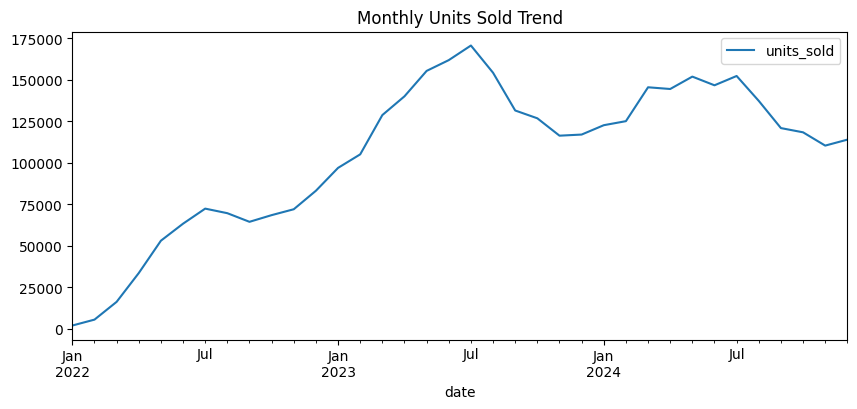

In [232]:
monthly_df = pd.read_sql("""
SELECT
    c.year,
    c.month,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
GROUP BY c.year, c.month
ORDER BY c.year, c.month
""", conn)

monthly_df["date"] = pd.to_datetime(
    monthly_df["year"].astype(str) + "-" + monthly_df["month"].astype(str) + "-01"
)

monthly_df.plot(x="date", y="units_sold", figsize=(10,4), title="Monthly Units Sold Trend")


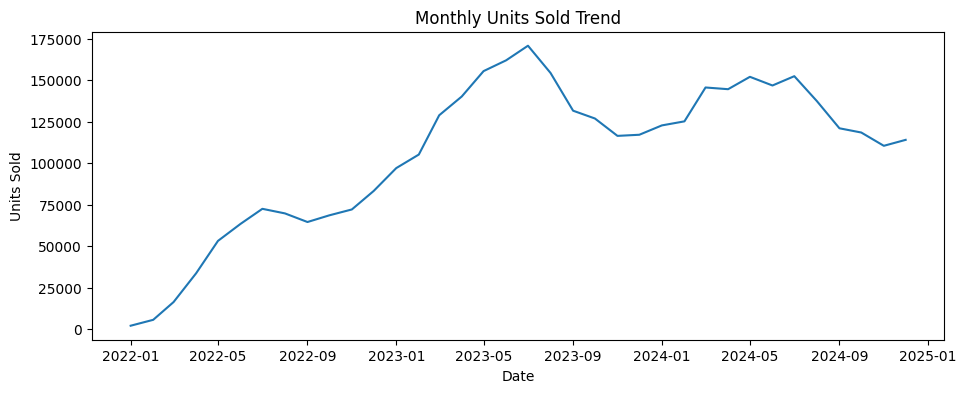

In [233]:
#monthly sales trend 
import matplotlib.pyplot as plt

monthly_df = pd.read_sql("""
SELECT
    c.year,
    c.month,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
GROUP BY c.year, c.month
ORDER BY c.year, c.month
""", conn)

monthly_df["date"] = pd.to_datetime(
    monthly_df["year"].astype(str) + "-" + monthly_df["month"].astype(str) + "-01"
)

plt.figure(figsize=(11,4))
plt.plot(monthly_df["date"], monthly_df["units_sold"])
plt.title("Monthly Units Sold Trend")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


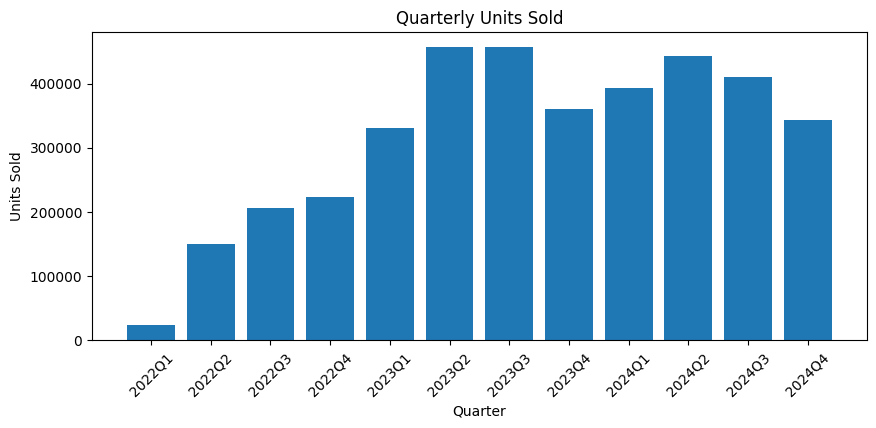

In [234]:
#quarterly sales trend
quarterly_df = pd.read_sql("""
SELECT
    c.quarter,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
GROUP BY c.quarter
ORDER BY c.quarter
""", conn)

plt.figure(figsize=(10,4))
plt.bar(quarterly_df["quarter"], quarterly_df["units_sold"])
plt.title("Quarterly Units Sold")
plt.xlabel("Quarter")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.show()


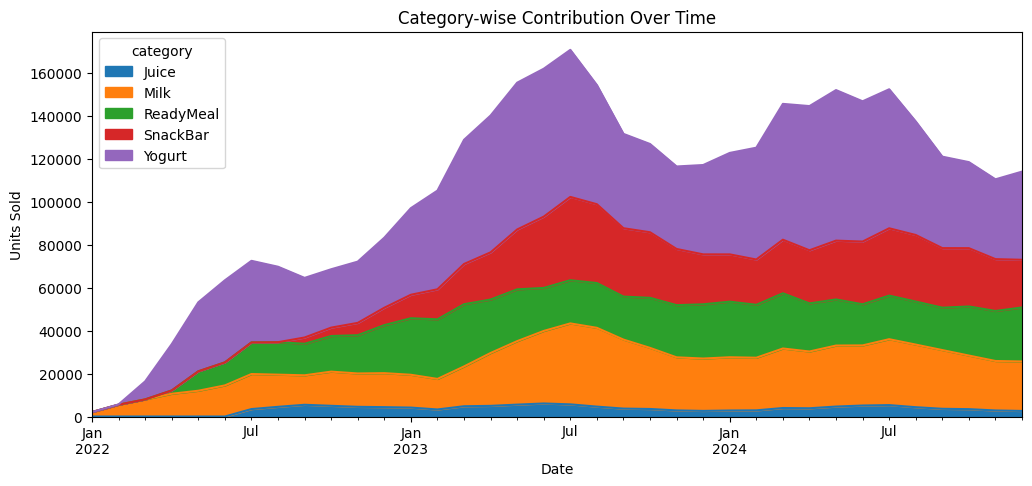

In [235]:
#category contribution 
cat_time_df = pd.read_sql("""
SELECT
    c.year,
    c.month,
    p.category,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
JOIN products p ON sf.product_id = p.product_id
GROUP BY c.year, c.month, p.category
ORDER BY c.year, c.month
""", conn)

cat_time_df["date"] = pd.to_datetime(
    cat_time_df["year"].astype(str) + "-" + cat_time_df["month"].astype(str) + "-01"
)

pivot_df = cat_time_df.pivot(index="date", columns="category", values="units_sold")

pivot_df.plot(kind="area", figsize=(12,5))
plt.title("Category-wise Contribution Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


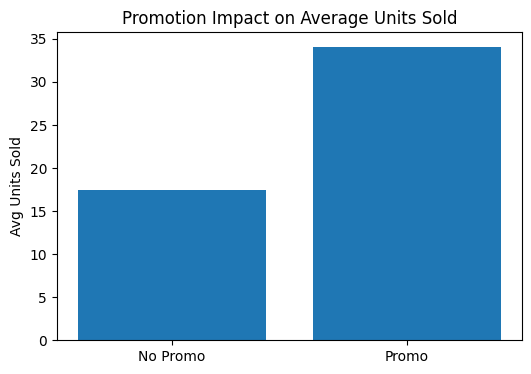

In [236]:
#promtion impact 
promo_df = pd.read_sql("""
SELECT
    promotion_flag,
    AVG(units_sold) AS avg_units_sold
FROM sales_fact
GROUP BY promotion_flag
""", conn)

promo_df["promotion_flag"] = promo_df["promotion_flag"].map({0:"No Promo", 1:"Promo"})

plt.figure(figsize=(6,4))
plt.bar(promo_df["promotion_flag"], promo_df["avg_units_sold"])
plt.title("Promotion Impact on Average Units Sold")
plt.ylabel("Avg Units Sold")
plt.show()


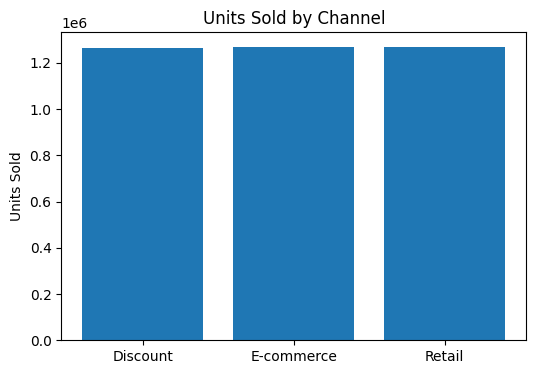

In [237]:
#channel performance 
channel_df = pd.read_sql("""
SELECT
    m.channel,
    SUM(sf.units_sold) AS units_sold
FROM sales_fact sf
JOIN markets m ON sf.market_id = m.market_id
GROUP BY m.channel
""", conn)

plt.figure(figsize=(6,4))
plt.bar(channel_df["channel"], channel_df["units_sold"])
plt.title("Units Sold by Channel")
plt.ylabel("Units Sold")
plt.show()


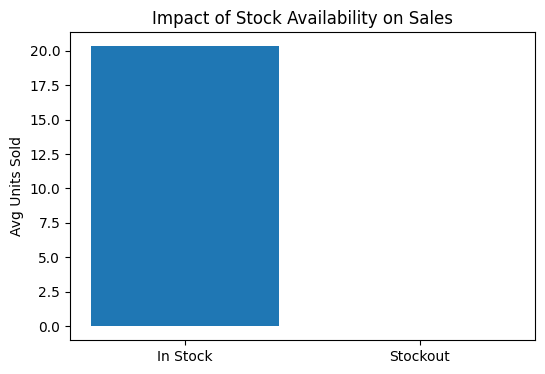

In [238]:
#stockout impact 
stock_df = pd.read_sql("""
SELECT
    CASE 
        WHEN stock_available <= 0 THEN 'Stockout'
        ELSE 'In Stock'
    END AS stock_status,
    AVG(units_sold) AS avg_units_sold
FROM sales_fact
GROUP BY stock_status
""", conn)

plt.figure(figsize=(6,4))
plt.bar(stock_df["stock_status"], stock_df["avg_units_sold"])
plt.title("Impact of Stock Availability on Sales")
plt.ylabel("Avg Units Sold")
plt.show()


## PHASE 6 : MACHINE LEARNING (FMCG DEMAND FORECASTING)

In [239]:
ml_df = pd.read_sql("""
SELECT
    sf.units_sold,
    sf.price_unit,
    sf.promotion_flag,
    sf.delivery_days,
    sf.stock_available,
    sf.product_id,
    sf.market_id,
    c.month,
    c.year,
    c.day_of_week
FROM sales_fact sf
JOIN calendar c ON sf.date = c.date
""", conn)


In [240]:
ml_df.head(), ml_df.shape


(   units_sold  price_unit  promotion_flag  delivery_days  stock_available  \
 0           9        2.38               0              1              141   
 1           0        1.55               1              3                0   
 2           8        4.00               0              5              118   
 3           7        5.16               0              2               81   
 4          12        7.66               0              4              148   
 
    product_id  market_id  month  year day_of_week  
 0          91         28      1  2022      Friday  
 1          91         29      1  2022      Friday  
 2          91         30      1  2022      Friday  
 3          91         31      1  2022      Friday  
 4          91         32      1  2022      Friday  ,
 (190757, 10))

In [241]:
ml_df.isnull().sum()


units_sold         0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
product_id         0
market_id          0
month              0
year               0
day_of_week        0
dtype: int64

In [242]:
ml_df["day_of_week"] = ml_df["day_of_week"].astype("category").cat.codes


In [243]:
import numpy as np
ml_df["units_sold_log"] = np.log1p(ml_df["units_sold"])


d:\project\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [253]:
train_df = ml_df[ml_df["year"] < 2024]
test_df  = ml_df[ml_df["year"] == 2024]

cols_to_drop = [c for c in ["units_sold", "units_sold_clean", "units_sold_log"] if c in train_df.columns]
X_train = train_df.drop(columns=cols_to_drop)
y_train = train_df["units_sold_log"] if "units_sold_log" in train_df.columns else None

cols_to_drop_test = [c for c in ["units_sold", "units_sold_clean", "units_sold_log"] if c in test_df.columns]
X_test = test_df.drop(columns=cols_to_drop_test)
y_test = test_df["units_sold_log"] if "units_sold_log" in test_df.columns else None


In [246]:
y_train.isnull().sum(), y_test.isnull().sum()


(np.int64(2), np.int64(1))

In [247]:
ml_df["units_sold"].describe()


count    190757.000000
mean         19.919709
std          11.770077
min         -25.000000
25%          12.000000
50%          18.000000
75%          25.000000
max         139.000000
Name: units_sold, dtype: float64

In [248]:
ml_df[ml_df["units_sold"] < 0].shape


(3, 11)

In [249]:
ml_df["units_sold_clean"] = ml_df["units_sold"].clip(lower=0)
ml_df["units_sold_log"] = np.log1p(ml_df["units_sold_clean"])


In [250]:
ml_df["units_sold_log"].isnull().sum()


np.int64(0)

In [251]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_log = lr.predict(X_test)
pred = np.expm1(pred_log)

mae = mean_absolute_error(test_df["units_sold_clean"], pred)
r2 = r2_score(test_df["units_sold_clean"], pred)

mae, r2


ValueError: Input y contains NaN.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Ensure target has no NaNs and align X/y
if y_train is None:
    raise ValueError("y_train is not set. Compute 'units_sold_log' before training.")
mask = y_train.notnull()
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

lr = LinearRegression()
lr.fit(X_train_clean, y_train_clean)

pred_log = lr.predict(X_test)
pred = np.expm1(pred_log)

# Compute metrics only if ground-truth is available
if "units_sold_clean" in test_df.columns:
    y_true = test_df["units_sold_clean"].values
    mae = mean_absolute_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    mae, r2
else:
    print("No 'units_sold_clean' in test_df — returning predictions head")
    pred[:5]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=18,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

pred_log = rf.predict(X_test)
pred = np.expm1(pred_log)

mae_rf = mean_absolute_error(test_df["units_sold_clean"], pred)
r2_rf = r2_score(test_df["units_sold_clean"], pred)

mae_rf, r2_rf


NameError: name 'mean_absolute_error' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Ensure y_train has no NaNs before fitting
if y_train is None:
    raise ValueError("y_train is not set. Compute 'units_sold_log' before training.")
mask = y_train.notnull()
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=18,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_clean, y_train_clean)

pred_log = rf.predict(X_test)
pred = np.expm1(pred_log)

if "units_sold_clean" in test_df.columns:
    y_true = test_df["units_sold_clean"].values
    mae_rf = mean_absolute_error(y_true, pred)
    r2_rf = r2_score(y_true, pred)
    mae_rf, r2_rf
else:
    print("No 'units_sold_clean' in test_df — returning predictions head")
    pred[:5]


In [ ]:
importance_df = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": rf.feature_importances_
    })
    .sort_values(by="importance", ascending=False)
)

importance_df


,feature,importance
3,stock_available,0.709898
1,promotion_flag,0.132669
6,month,0.055796
4,product_id,0.055261
0,price_unit,0.016040
7,year,0.010199
5,market_id,0.007896
8,day_of_week,0.006738
2,delivery_days,0.005503


In [ ]:
ml_df["stock_available_capped"] = ml_df["stock_available"].clip(upper=300)



In [ ]:
ml_df = ml_df.sort_values(["product_id", "market_id", "year", "month"])


In [ ]:
ml_df["units_lag_1"] = ml_df.groupby(
    ["product_id", "market_id"]
)["units_sold_clean"].shift(1)

ml_df["units_lag_3"] = ml_df.groupby(
    ["product_id", "market_id"]
)["units_sold_clean"].shift(3)


In [ ]:
ml_df[["units_lag_1", "units_lag_3"]] = (
    ml_df[["units_lag_1", "units_lag_3"]].fillna(0)
)


In [ ]:
features = [
    "price_unit",
    "promotion_flag",
    "delivery_days",
    "stock_available_capped",
    "product_id",
    "market_id",
    "month",
    "units_lag_1",
    "units_lag_3"
]

target = "units_sold_log"


In [ ]:
train_df = ml_df[ml_df["year"] < 2024]
test_df  = ml_df[ml_df["year"] == 2024]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=10,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

pred_log = rf.predict(X_test)
pred = np.expm1(pred_log)

mae_rf = mean_absolute_error(test_df["units_sold_clean"], pred)
r2_rf = r2_score(test_df["units_sold_clean"], pred)

mae_rf, r2_rf


(4.080256023771848, 0.7221459930819024)

In [ ]:
test_df = test_df.copy()
test_df["predicted_units"] = pred


In [ ]:
monthly_actual = (
    test_df.groupby("month")["units_sold_clean"]
    .sum()
    .reset_index(name="actual_units")
)

monthly_pred = (
    test_df.groupby("month")["predicted_units"]
    .sum()
    .reset_index(name="predicted_units")
)

monthly_compare = monthly_actual.merge(monthly_pred, on="month")
monthly_compare


,month,actual_units,predicted_units
0,1,122689,133180.167098
1,2,125124,131031.587707
2,3,145526,149093.260380
3,4,144487,145052.673806
4,5,151938,152434.897675
5,6,146716,149501.814124
6,7,152320,157319.663577
7,8,137328,148000.662844
8,9,120951,128590.565453
9,10,118405,121951.979565


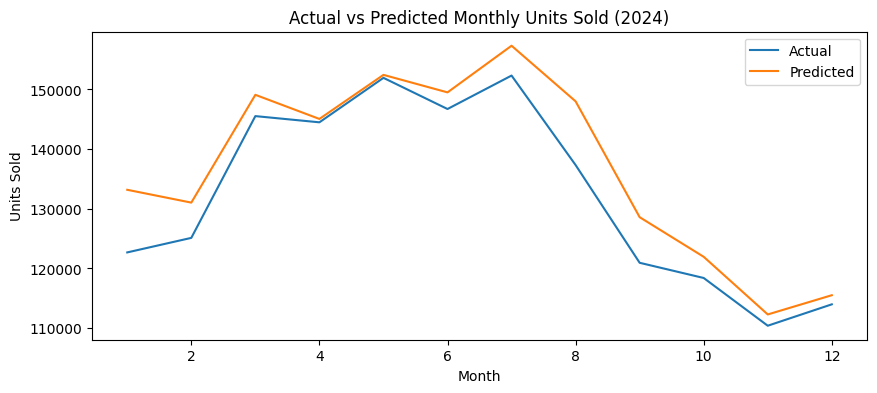

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(monthly_compare["month"], monthly_compare["actual_units"], label="Actual")
plt.plot(monthly_compare["month"], monthly_compare["predicted_units"], label="Predicted")
plt.title("Actual vs Predicted Monthly Units Sold (2024)")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


In [ ]:
scenario_df = X_test.copy()

scenario_df["promotion_flag"] = 0
pred_no_promo = np.expm1(rf.predict(scenario_df))

scenario_df["promotion_flag"] = 1
pred_promo = np.expm1(rf.predict(scenario_df))

print(
    "Avg units without promo:", pred_no_promo.mean(),
    "\nAvg units with promo:", pred_promo.mean()
)


Avg units without promo: 17.23624612758857 
Avg units with promo: 33.10535030058532


In [ ]:
scenario_df = X_test.copy()

scenario_df["stock_available_capped"] *= 0.8
pred_low_stock = np.expm1(rf.predict(scenario_df))

print(
    "Avg units normal stock:", pred.mean(),
    "\nAvg units with 20% stock drop:", pred_low_stock.mean()
)


Avg units normal stock: 19.58039036212943 
Avg units with 20% stock drop: 15.73230012376509


In [ ]:
train_22 = ml_df[ml_df["year"] == 2022]
test_23  = ml_df[ml_df["year"] == 2023]

X_train_22 = train_22[features]
y_train_22 = train_22[target]

X_test_23 = test_23[features]
y_test_23 = test_23["units_sold_clean"]

rf_22 = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf_22.fit(X_train_22, y_train_22)
pred_23 = np.expm1(rf_22.predict(X_test_23))

mean_absolute_error(y_test_23, pred_23), r2_score(y_test_23, pred_23)


(6.09789794710958, 0.49103044285000697)

## PHASE 7 : NLP JARVIS (FMCG ANALYTICS ASSISTANT)

In [ ]:
from fmcg_jarvis.jarvis import ask_jarvis


ModuleNotFoundError: No module named 'jarvis_nlp'

In [ ]:
ask_jarvis(
    "What if stock drops by 20%?",
    conn,
    rf,
    X_test
)


NameError: name 'ask_jarvis' is not defined